In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sympy import divisors
from dataclasses import dataclass
import math
from typing import Callable
from copy import deepcopy
import matplotlib.cm as cm

## Language model and GPU definitions

This section contains a transformer class and a GPU class, along with object definitions for important models and GPUs. Details such as whether a GPU should be assumed to have a kernel launch latency or what the latency structure of GPU collectives is like are also handled here.

By default, we use the latency function from the NCCL Tests repository. These might correspond to collective kernels that have been insufficiently optimized - to get results in a more optimized setting, you can adjust the functions implementing time taken per collective as needed.

In [2]:
class Model:
    def __init__(self, name="None", d_model=3*2**12, d_ff=9*2**12, ff_matrix_count=(1, 1), layers=120, n_experts=1, n_active_experts=1, num_query_heads=128, group_size=1, \
                 weight_precision_bytes=2, activation_precision_bytes=2, d_head=None, vocab_size=0, parallel_attention=False):
        assert num_query_heads % group_size == 0

        # Variables directly set
        self.d_model = d_model
        self.d_ff = d_ff
        self.layers = layers
        self.n_experts = n_experts
        self.n_active_experts = n_active_experts
        self.num_query_heads = num_query_heads
        self.group_size = group_size
        self.weight_precision_bytes = weight_precision_bytes
        self.activation_precision_bytes = activation_precision_bytes
        self.vocab_size = vocab_size
        self.ff_matrix_count = ff_matrix_count
        self.parallel_attention = parallel_attention

        # Derived variables
        self.ff_params_per_layer_per_expert = sum(self.ff_matrix_count) * self.d_model * self.d_ff
        self.sparsity_factor = self.n_experts // self.n_active_experts
        self.total_ff_params = self.layers * self.n_experts * self.ff_params_per_layer_per_expert
        self.num_kv_heads = 2 * self.num_query_heads / self.group_size
        self.d_head = d_head if d_head != None else self.d_model // self.num_query_heads
        self.d_all_attn_heads = (self.num_query_heads + self.num_kv_heads) * self.d_head
        self.attn_params_per_layer = self.d_all_attn_heads * self.d_model + self.d_head*self.num_query_heads*self.d_model

        self.embedding_params = self.vocab_size * self.d_model * 2
        self.total_attn_params = self.layers * self.attn_params_per_layer
        self.total_params = self.total_attn_params + self.total_ff_params + self.embedding_params
        self.total_active_params = self.total_attn_params + self.total_ff_params//self.sparsity_factor + self.embedding_params

        self.kv_cache_size_per_input_bytes = self.num_kv_heads*self.d_head*self.layers*self.activation_precision_bytes

        self.name = name

    def __repr__(self):
        representation = f"""Model Details:
        Name: {self.name}
        d_model: {self.d_model}
        d_ff: {self.d_ff}
        Depth: {self.layers}
        Total FF Params: {self.total_ff_params}
        Total Embedding Params: {self.embedding_params}
        Num Attention Heads: {self.num_query_heads}
        d_head: {self.d_head}
        Group size: {self.group_size}
        Total Attention Params: {self.total_attn_params}
        Total Params: {self.total_params}
        Total Active Params: {self.total_active_params}
        """
        return representation

    def arithmetic_cost_flop(self, input_len, batch_size, seq_len=1):
        mean_input_len = (input_len + (input_len + seq_len - 1))/2
        return (2*self.total_active_params*batch_size*seq_len + 4*self.d_head*self.num_query_heads*self.layers*mean_input_len*batch_size*seq_len)

    def memory_reads_writes_bytes(self, input_len, batch_size, seq_len, tp_first_dim, tp_second_dim):
        batch_size_tokens = batch_size*seq_len
        kv_cache_size_bytes = self.kv_cache_size_per_input_bytes*input_len*batch_size

        used_experts_fraction = (1 - (1 - 1/self.sparsity_factor)**batch_size_tokens)
        wp = self.weight_precision_bytes
        ap = self.activation_precision_bytes

        feedforward_matmul_rw_bytes = used_experts_fraction * self.n_experts * sum(self.ff_matrix_count) * \
                                         (wp*self.d_model*self.d_ff + tp_second_dim*ap*self.d_model*batch_size_tokens/self.sparsity_factor + \
                                          tp_first_dim*ap*self.d_ff*batch_size_tokens/self.sparsity_factor)

        qkv_matmul_rw_bytes = wp*self.d_model*self.d_all_attn_heads + tp_second_dim*ap*(self.d_model*batch_size_tokens) + tp_first_dim*(self.d_all_attn_heads*batch_size_tokens)

        proj_matmul_rw_bytes = wp*self.d_head*self.num_query_heads*self.d_model + \
                               ap*(tp_second_dim*self.d_model*batch_size_tokens + tp_first_dim*self.d_head*self.num_query_heads*batch_size_tokens)

        unembedding_bytes = wp*self.vocab_size*self.d_model

        return kv_cache_size_bytes + self.layers*(feedforward_matmul_rw_bytes + qkv_matmul_rw_bytes + proj_matmul_rw_bytes) + unembedding_bytes

GPT_4 = Model(name="GPT-4",
              d_model=12288,
              d_ff=3*12288,
              layers=120,
              n_experts=16,
              n_active_experts=2,
              num_query_heads=96,
              group_size=96,
              d_head=3*12288//(2*96),
              activation_precision_bytes=2,
              weight_precision_bytes=2,
              vocab_size=100256,
)

GPT_3_5 = Model(name="GPT 3.5",
                d_model=2**9 * 3**2,
                d_ff=4 * 2**9 * 3**2,
                layers=32,
                n_experts=4,
                n_active_experts=2,
                num_query_heads=32,
                group_size=32,
                activation_precision_bytes=2,
                weight_precision_bytes=2
)

GPT_3 = Model(name="GPT-3",
              d_model=12288,
              d_ff=4*12288,
              layers=96,
              n_experts=1,
              n_active_experts=1,
              num_query_heads=96,
              d_head=128,
              activation_precision_bytes=2,
              weight_precision_bytes=2,
              vocab_size=50257
)

PaLM_540B = Model(name="PaLM 540B",
                  d_model=18432,
                  d_ff=73728,
                  ff_matrix_count=(2, 1),
                  layers=118,
                  n_experts=1,
                  n_active_experts=1,
                  num_query_heads=48,
                  d_head=256,
                  group_size=48,
                  activation_precision_bytes=2,
                  weight_precision_bytes=2,
                  vocab_size=256000,
                  parallel_attention=True
)

PaLM_8B = Model(name="PaLM 8B",
                d_model=4096,
                d_ff=4*4096,
                ff_matrix_count=(2, 1),
                layers=32,
                num_query_heads=16,
                group_size=16,
                d_head=256,
                activation_precision_bytes=2,
                weight_precision_bytes=1,
                vocab_size=256000,
                parallel_attention=True
)

Falcon = Model(name="Falcon 180B",
               d_model=14848,
               d_ff=4*14848,
               layers=80,
               d_head=64,
               num_query_heads=232,
               group_size=232,
               activation_precision_bytes=2,
               weight_precision_bytes=2,
               vocab_size=65024
)

GPT_J_6B = Model(name="GPT-J 6B",
                 d_model=4096,
                 d_ff=4*4096,
                 layers=28,
                 num_query_heads=16,
                 d_head=256,
                 group_size=1,
                 activation_precision_bytes=2,
                 weight_precision_bytes=2,
                 vocab_size=50257
)

Mixtral_8x22B = Model(name="Mixtral 8x22B",
                      d_model=6144,
                      d_ff=16384,
                      ff_matrix_count=(2, 1),
                      layers=56,
                      n_experts=8,
                      n_active_experts=2,
                      num_query_heads=48,
                      d_head=128,
                      group_size=6,
                      activation_precision_bytes=2,
                      weight_precision_bytes=2,
                      vocab_size=32000
)

Mixtral_8x22B_MQA = Model(name="Mixtral 8x22B MQA",
                      d_model=6144,
                      d_ff=16384,
                      ff_matrix_count=(2, 1),
                      layers=56,
                      n_experts=8,
                      n_active_experts=2,
                      num_query_heads=48,
                      d_head=128,
                      group_size=48,
                      activation_precision_bytes=2,
                      weight_precision_bytes=2,
                      vocab_size=32000
)

Mixtral_8x7B = Model(name="Mixtral 8x7B",
                      d_model=4096,
                      d_ff=14336,
                      ff_matrix_count=(2, 1),
                      layers=32,
                      n_experts=8,
                      n_active_experts=2,
                      num_query_heads=32,
                      group_size=4,
                     activation_precision_bytes=2,
                      weight_precision_bytes=2,
                      vocab_size=32000
)

Mistral_Large_2 = Model(name="Mistral Large 2",
                        d_model=12288,
                        d_ff=28672,
                        ff_matrix_count=(2, 1),
                        layers=88,
                        n_experts=1,
                        n_active_experts=1,
                        num_query_heads=96,
                        group_size=12,
                        activation_precision_bytes=2,
                        weight_precision_bytes=2,
                        vocab_size=32768
)

Llama_3_8B = Model(name="LLaMa 3 8B",
                    d_model=4096,
                    d_ff=14336,
                    ff_matrix_count=(2, 1),
                    layers=32,
                    n_experts=1,
                    n_active_experts=1,
                    num_query_heads=32,
                    group_size=4,
                    activation_precision_bytes=2,
                    weight_precision_bytes=2,
                    vocab_size=128256
)

Llama_3_8B_MQA = Model(name="LLaMa 3 8B MQA",
                    d_model=4096,
                    d_ff=14336,
                    ff_matrix_count=(2, 1),
                    layers=32,
                    n_experts=1,
                    n_active_experts=1,
                    num_query_heads=32,
                    group_size=32,
                    activation_precision_bytes=2,
                    weight_precision_bytes=2,
                    vocab_size=128256
)

Llama_3_8B_8_bit = Model(name="LLaMa 3 8B",
                        d_model=4096,
                        d_ff=14336,
                        ff_matrix_count=(2, 1),
                        layers=32,
                        n_experts=1,
                        n_active_experts=1,
                        num_query_heads=32,
                        group_size=4,
                        activation_precision_bytes=1,
                        weight_precision_bytes=2,
                        vocab_size=128256
)

Llama_3_70B = Model(name="LLaMa 3 70B",
                    d_model=8192,
                    d_ff=28672,
                    ff_matrix_count=(2, 1),
                    layers=80,
                    n_experts=1,
                    n_active_experts=1,
                    num_query_heads=64,
                    group_size=8,
                    activation_precision_bytes=2,
                    weight_precision_bytes=2,
                    vocab_size=128256
)

Llama_3_70B_MQA = Model(name="LLaMa 3 70B MQA",
                    d_model=8192,
                    d_ff=28672,
                    ff_matrix_count=(2, 1),
                    layers=80,
                    n_experts=1,
                    n_active_experts=1,
                    num_query_heads=64,
                    group_size=64,
                    activation_precision_bytes=2,
                    weight_precision_bytes=2,
                    vocab_size=128256
)

Llama_3_70B_8_bit = Model(name="LLaMa 3 70B 8-bit",
                    d_model=8192,
                    d_ff=28672,
                    ff_matrix_count=(2, 1),
                    layers=80,
                    n_experts=1,
                    n_active_experts=1,
                    num_query_heads=64,
                    group_size=8,
                    activation_precision_bytes=2,
                    weight_precision_bytes=1,
                    vocab_size=128256
)

Llama_3_70B_4_bit = Model(name="LLaMa 3 70B 4-bit",
                    d_model=8192,
                    d_ff=28672,
                    ff_matrix_count=(2, 1),
                    layers=80,
                    n_experts=1,
                    n_active_experts=1,
                    num_query_heads=64,
                    group_size=8,
                    activation_precision_bytes=2,
                    weight_precision_bytes=0.5,
                    vocab_size=128256
)

Llama_3_405B = Model(name="LLaMa 3 405B",
                    d_model=16384,
                    d_ff=53248,
                    ff_matrix_count=(2, 1),
                    layers=126,
                    n_experts=1,
                    n_active_experts=1,
                    num_query_heads=128,
                    group_size=8,
                    activation_precision_bytes=2,
                    weight_precision_bytes=2,
                    vocab_size=128256
)

Llama_3_405B_8_bit = Model(name="LLaMa 3 405B",
                    d_model=16384,
                    d_ff=53248,
                    ff_matrix_count=(2, 1),
                    layers=126,
                    n_experts=1,
                    n_active_experts=1,
                    num_query_heads=128,
                    group_size=8,
                    activation_precision_bytes=2,
                    weight_precision_bytes=1,
                    vocab_size=128256
)

def scale_model(model: Model, scale_factor: float, depth_exponent=1/3):
    d_model = model.d_model * scale_factor**((1 - depth_exponent)/2)  
    d_ff = model.d_ff * scale_factor**((1 - depth_exponent)/2)
    layers = int(model.layers * scale_factor**(depth_exponent))

    num_query_heads = np.ceil(model.num_query_heads * scale_factor**((1 - depth_exponent)/4))
    num_groups = model.num_query_heads/model.group_size
    group_size = num_query_heads/num_groups

    return Model(name=model.name,
                 d_model=d_model,
                 d_ff=d_ff,
                 ff_matrix_count=model.ff_matrix_count,
                 layers=layers,
                 n_experts=model.n_experts,
                 n_active_experts=model.n_active_experts,
                 num_query_heads=num_query_heads,
                 group_size=group_size,
                 d_head=model.d_head * scale_factor**((1 - depth_exponent)/4),
                 weight_precision_bytes=model.weight_precision_bytes,
                 activation_precision_bytes=model.activation_precision_bytes,
                 vocab_size=model.vocab_size,
                 parallel_attention=model.parallel_attention
                 )

GPT_4_100T_param = scale_model(GPT_4, 50)
GPT_4_2x = scale_model(GPT_4, 1/2)
GPT_4_4x = scale_model(GPT_4, 1/4)
GPT_4_8x = scale_model(GPT_4, 1/8)
GPT_4_16x = scale_model(GPT_4, 1/16)

Llama_3_gpt4_size = scale_model(Llama_3_405B, 4.444, depth_exponent=0)
Llama_3_gpt4_size_2x = scale_model(Llama_3_gpt4_size, 1/2)
Llama_3_gpt4_size_4x = scale_model(Llama_3_gpt4_size, 1/4)
Llama_3_gpt4_size_8x = scale_model(Llama_3_gpt4_size, 1/8)
Llama_3_gpt4_size_16x = scale_model(Llama_3_gpt4_size, 1/16)

GPT_4_100T_param.name = "GPT 4 with 100T params"

class GPU:
    name: str
    flop_per_second: float
    theoretical_flop_per_second: float
    hbm_bandwidth_Bps: float
    theoretical_hbm_bandwidth_Bps: float
    hbm_size_bytes: float
    l2_bandwidth_Bps: float
    l2_cache_size_bytes: float
    intranode_allreduce_bandwidth_Bps: float
    internode_allreduce_bandwidth_Bps: float
    node_size: int
    price_dollars_per_hour: float
    kernel_launch_latency_seconds: float
    collective_time_seconds: Callable[[float, float, float, 'GPU', str, tuple[int]], float]

    def __init__(self,
                 name: str,
                 flop_per_second: dict,
                 hbm_bandwidth_Bps: float,
                 hbm_size_bytes: float,
                 l2_bandwidth_Bps: float,
                 l2_cache_size_bytes: float,
                 intranode_allreduce_bandwidth_Bps: float,
                 internode_allreduce_bandwidth_Bps: float,
                 node_size: int,
                 price_dollars_per_hour: float,
                 kernel_launch_latency_seconds: float,
                 collective_time_seconds: Callable[[float, float, float, 'GPU', str, tuple[int]], float],
                 arithmetic_utilization_cap=1,
                 memory_bwd_utilization_cap=1):
        self.name = name
        self.theoretical_flop_per_second = flop_per_second
        self.theoretical_hbm_bandwidth_Bps = hbm_bandwidth_Bps
        self.flop_per_second = {p: flop_per_second[p]*arithmetic_utilization_cap for p in flop_per_second}
        self.hbm_bandwidth_Bps = hbm_bandwidth_Bps*memory_bwd_utilization_cap
        self.hbm_size_bytes = hbm_size_bytes
        self.l2_bandwidth_Bps = l2_bandwidth_Bps
        self.l2_cache_size_bytes = l2_cache_size_bytes
        self.intranode_allreduce_bandwidth_Bps = intranode_allreduce_bandwidth_Bps
        self.internode_allreduce_bandwidth_Bps = internode_allreduce_bandwidth_Bps
        self.node_size = node_size
        self.price_dollars_per_hour = price_dollars_per_hour
        self.kernel_launch_latency_seconds = kernel_launch_latency_seconds
        self.collective_time_seconds = collective_time_seconds
        self.arithmetic_utilization_cap = arithmetic_utilization_cap
        self.memory_bwd_utilization_cap = memory_bwd_utilization_cap

def collective_latency_nccl_seconds(nRanks, nNodes, coll="allreduce", algo="LL", ll_base_latency_seconds=6.8e-6, ll128_base_latency_seconds=14e-6):
   if coll == "allreduce":
     m = 2
   else:
     m = 1

   if algo == "LL":
      return m * ((nRanks/nNodes - 1)*0.6e-6 + 5e-6*np.log2(nNodes)) + ll_base_latency_seconds
   elif algo == "LL128":
      return m * ((nRanks/nNodes - 1)*1.25e-6 + 8.5e-6*np.log2(nNodes)) + ll128_base_latency_seconds
   elif algo == "Simple":
      return m * ((nRanks/nNodes - 1)*28e-6 + 28e-6*np.log2(nNodes))
   else:
      raise ValueError("Algorithm code given to collective_latency_nccl_seconds is invalid.")

def mean_collective_time_nccl_seconds(nRanks, nNodes, bytes_reduced, gpu: GPU, coll="allreduce", latency_bw_weights=(1, 1), ll_base_latency_seconds=6.8e-6, ll128_base_latency_seconds=14e-6, overlap_comms=True):
    result = np.infty * np.ones(shape=np.shape(nRanks))
    weighted_result = np.infty * np.ones(shape=np.shape(nRanks))

    assert np.all(nNodes <= np.maximum(1, nRanks)) and np.all(nNodes >= nRanks/gpu.node_size)

    if coll == "allreduce":
        m = 2
    else:
        m = 1

    algorithm_bandwidth_factors = {"Simple": 1,
                                    "LL128": 0.95,
                                    "LL": 0.5}

    if coll == "p2p":
       assert np.all(nRanks == 2)

    lat_weight, bw_weight = latency_bw_weights

    for algo in algorithm_bandwidth_factors:
      bw_factor = algorithm_bandwidth_factors[algo]
      curr_latency_time_seconds = collective_latency_nccl_seconds(nRanks, nNodes, coll=coll, algo=algo, ll_base_latency_seconds=ll_base_latency_seconds, ll128_base_latency_seconds=ll128_base_latency_seconds)

      if overlap_comms:
        curr_bw_time_seconds = np.maximum(nNodes*np.maximum(0, nRanks/nNodes - 1)*bytes_reduced/(nRanks*gpu.intranode_allreduce_bandwidth_Bps*bw_factor), \
                                         (nNodes-1)*bytes_reduced/(nRanks*gpu.internode_allreduce_bandwidth_Bps*bw_factor))
      else:
        curr_bw_time_seconds = nNodes*np.maximum(0, nRanks/nNodes - 1)*bytes_reduced/(nRanks*gpu.intranode_allreduce_bandwidth_Bps*bw_factor) + \
                                (nNodes-1)*bytes_reduced/(nRanks*gpu.internode_allreduce_bandwidth_Bps*bw_factor)
      
      if coll != "allreduce":
       curr_bw_time_seconds /= 2

      nonlinear_correction_time_seconds = np.zeros(shape=np.shape(nRanks))

      curr_result = curr_latency_time_seconds + curr_bw_time_seconds + nonlinear_correction_time_seconds
      smaller_indices = np.where(curr_result < result)

      result = np.minimum(result, curr_latency_time_seconds + curr_bw_time_seconds + nonlinear_correction_time_seconds)

      weighted_result[smaller_indices] = lat_weight*curr_latency_time_seconds[smaller_indices] + \
                                         bw_weight*curr_bw_time_seconds[smaller_indices] + \
                                         bw_weight*nonlinear_correction_time_seconds[smaller_indices]

    result[np.where(nRanks <= 1)] = 0
    weighted_result[np.where(nRanks <= 1)] = 0

    return weighted_result

def tpu_collective_time_seconds(nRanks, nNodes, bytes_reduced, gpu: GPU, coll="allreduce", latency_bw_weights=(1, 1)):
    if coll == "allreduce":
        m = 2
    else:
        m = 1

    if coll == "p2p":
        assert np.all(nRanks == 2)

    lat_weight, bw_weight = latency_bw_weights

    curr_latency_time_seconds = m*(nRanks-1)*1e-6
    curr_bw_time_seconds = (nRanks-1)*bytes_reduced/(nRanks*gpu.internode_allreduce_bandwidth_Bps)

    if coll != "allreduce":
       curr_bw_time_seconds /= 2

    nonlinear_correction_time_seconds = np.zeros(shape=np.shape(nRanks)) # 1e-6 * bytes_reduced**0.3345
    result = lat_weight*curr_latency_time_seconds + bw_weight*curr_bw_time_seconds + bw_weight*nonlinear_correction_time_seconds

    result[np.where(nRanks <= 1)] = 0
    return result


H100 = GPU(name="H100",
           flop_per_second={4: 2e15, 8: 2e15, 16: 1e15},
           hbm_bandwidth_Bps=3.3e12,
           hbm_size_bytes=8e10,
           l2_cache_size_bytes=2.5e7,
           l2_bandwidth_Bps=1.2e13,
           intranode_allreduce_bandwidth_Bps=9e11/4,
           internode_allreduce_bandwidth_Bps=5e10/2,
           node_size=8,
           price_dollars_per_hour=3.15*2/3,
           kernel_launch_latency_seconds=4e-6,
           collective_time_seconds=mean_collective_time_nccl_seconds,
           arithmetic_utilization_cap=1,
           memory_bwd_utilization_cap=1
)

H800 = GPU(name="H800",
           flop_per_second={4: 2e15, 8: 2e15, 16: 1e15},
           hbm_bandwidth_Bps=3.3e12,
           hbm_size_bytes=8e10,
           l2_cache_size_bytes=2.5e7,
           l2_bandwidth_Bps=1.2e13,
           intranode_allreduce_bandwidth_Bps=4e11/4,
           internode_allreduce_bandwidth_Bps=5e10/2,
           node_size=8,
           price_dollars_per_hour=3.15*2/3,
           kernel_launch_latency_seconds=4e-6,
           collective_time_seconds=mean_collective_time_nccl_seconds,
           arithmetic_utilization_cap=1,
           memory_bwd_utilization_cap=1
)

H20 = GPU(name="H20",
           flop_per_second={4: 2*148e12, 8: 2*148e12, 16: 148e12},
           hbm_bandwidth_Bps=4e12,
           hbm_size_bytes=96e9,
           l2_cache_size_bytes=2.5e7,
           l2_bandwidth_Bps=1.2e13,
           intranode_allreduce_bandwidth_Bps=9e11/4,
           internode_allreduce_bandwidth_Bps=5e10/2,
           node_size=8,
           price_dollars_per_hour=(13.5/24) * 3.15*2/3,
           kernel_launch_latency_seconds=4e-6,
           collective_time_seconds=mean_collective_time_nccl_seconds,
           arithmetic_utilization_cap=1,
           memory_bwd_utilization_cap=1
)

H100_ZL = GPU(name="H100 ZL",
           flop_per_second={4: 2e15, 8: 2e15, 16: 1e15},
           hbm_bandwidth_Bps=3.3e12,
           hbm_size_bytes=8e10,
           l2_cache_size_bytes=2.5e7,
           l2_bandwidth_Bps=1.2e13,
           intranode_allreduce_bandwidth_Bps=9e11/4,
           internode_allreduce_bandwidth_Bps=5e10/2,
           node_size=8,
           price_dollars_per_hour=3.15*2/3,
           kernel_launch_latency_seconds=0,
           collective_time_seconds=lambda x, y, z, gpu, coll, latency_bw_weights: mean_collective_time_nccl_seconds(x, y, z, gpu, coll, latency_bw_weights, ll_base_latency_seconds=0, ll128_base_latency_seconds=0),
           arithmetic_utilization_cap=1,
           memory_bwd_utilization_cap=1
)

H200 = GPU(name="H200",
           flop_per_second={4: 2e15, 8: 2e15, 16: 1e15},
           hbm_bandwidth_Bps=4.8e12,
           hbm_size_bytes=141e9,
           l2_cache_size_bytes=2.5e7,
           l2_bandwidth_Bps=1.2e13,
           intranode_allreduce_bandwidth_Bps=9e11/4,
           internode_allreduce_bandwidth_Bps=5e10/2,
           node_size=8,
           price_dollars_per_hour=3.5/2.5 * 3.15*2/3,
           kernel_launch_latency_seconds=4e-6,
           collective_time_seconds=mean_collective_time_nccl_seconds,
           arithmetic_utilization_cap=1,
           memory_bwd_utilization_cap=1)
      

A100 = GPU(name="A100",
           flop_per_second={8: 6.24e14, 16: 3.12e14},
           hbm_bandwidth_Bps=2e12,
           hbm_size_bytes=8e10,
           l2_cache_size_bytes=2.5e7,
           l2_bandwidth_Bps=1.2e13,
           intranode_allreduce_bandwidth_Bps=6e11/4,
           internode_allreduce_bandwidth_Bps=2.5e10/2,
           node_size=8,
           price_dollars_per_hour=2.26*2/3,
           kernel_launch_latency_seconds=4e-6,
           collective_time_seconds=mean_collective_time_nccl_seconds,
           arithmetic_utilization_cap=1,
           memory_bwd_utilization_cap=1
)
V100 = GPU(name="V100",
           flop_per_second={8: 1e14, 16: 1e14},
           hbm_bandwidth_Bps=9e11,
           hbm_size_bytes=1.6e10,
           l2_cache_size_bytes=2.5e7,
           l2_bandwidth_Bps=3e12,
           intranode_allreduce_bandwidth_Bps=3e11/4,
           internode_allreduce_bandwidth_Bps=1.25e10/2,
           node_size=8,
           price_dollars_per_hour=0.63*2/3,
           kernel_launch_latency_seconds=4e-6,
           collective_time_seconds=mean_collective_time_nccl_seconds,
           arithmetic_utilization_cap=1,
           memory_bwd_utilization_cap=1
)
TPU_v4 = GPU(name="TPU v4",
             flop_per_second={8: 2.6e14, 16: 2.6e14},
             hbm_bandwidth_Bps=1.6e12,
             hbm_size_bytes=32e9,
             l2_cache_size_bytes=5e4,
             l2_bandwidth_Bps=6.44e12,
             intranode_allreduce_bandwidth_Bps=np.infty,
             internode_allreduce_bandwidth_Bps=2.5e11,
             node_size=1,
             price_dollars_per_hour=1,
             kernel_launch_latency_seconds=4e-6,
             collective_time_seconds=tpu_collective_time_seconds,
)
Groq_LPU = GPU(name="Groq LPU",
               flop_per_second={8: 750e12, 16: 188e12},
               hbm_bandwidth_Bps=8e13,
               hbm_size_bytes=230e6,
               l2_cache_size_bytes=0,
               l2_bandwidth_Bps=np.infty,
               intranode_allreduce_bandwidth_Bps=np.infty,
               internode_allreduce_bandwidth_Bps=330e9/2,
               node_size=1,
               price_dollars_per_hour=1,
               kernel_launch_latency_seconds=4e-6,
               collective_time_seconds=tpu_collective_time_seconds,
)

In [3]:
print(Mixtral_8x22B)

Model Details:
        Name: Mixtral 8x22B
        d_model: 6144
        d_ff: 16384
        Depth: 56
        Total FF Params: 135291469824
        Total Embedding Params: 393216000
        Num Attention Heads: 48
        d_head: 128
        Group size: 6
        Total Attention Params: 4932501504.0
        Total Params: 140617187328.0
        Total Active Params: 39148584960.0
        


## Token latency functions

This section implements all of the token latency functions that are discussed in the paper, and an additional more complex one that handles complications such as pipeline parallelism.

In [4]:
def section_2_2_token_latency_seconds(N_GPU, model: Model, gpu: GPU, batch_size, input_len=0):
   t_reduce_seconds = 2e-6 * np.maximum(N_GPU**(1/2) - 1, 0) + 6e-6
   t_matmul_seconds = 0

   if model.parallel_attention:
      allreduces_per_layer = 2
   else:
      allreduces_per_layer = 4

   result = model.layers*allreduces_per_layer*t_reduce_seconds + np.maximum(model.weight_precision_bytes*model.total_params/(N_GPU*gpu.hbm_bandwidth_Bps), \
                                                                                    2*model.total_params*batch_size/(N_GPU*gpu.flop_per_second[8*model.weight_precision_bytes]))
   kv_cache_size_bytes = model.kv_cache_size_per_input_bytes * input_len * batch_size
   result[np.where(N_GPU * gpu.hbm_size_bytes < kv_cache_size_bytes + model.weight_precision_bytes*model.total_params)] = float("inf")

   return result

"""
The token latency function as presented in the paper.
This implementation follows the description in Section 3.5 exactly.
"""
def token_latency_seconds_as_presented_in_paper(N_GPU, model: Model, gpu: GPU, batch_size, input_len=0, seq_len=1):
   serial_matmuls_per_layer = 4
   nRanks = N_GPU**(1/2)
   nNodes = np.ceil(N_GPU/gpu.node_size)**(1/2)
   nParallelReduces = N_GPU/nRanks

   words_reduced = [model.d_head*(model.num_kv_heads + model.num_query_heads)/nParallelReduces, model.d_model/nParallelReduces, \
                    model.n_active_experts*model.ff_matrix_count[0]*model.d_ff/nParallelReduces, \
                    model.n_active_experts*model.ff_matrix_count[1]*model.d_model/nParallelReduces]

   arithmetic_cost_flop = model.arithmetic_cost_flop(input_len, batch_size*seq_len)
   kv_cache_size_bytes = model.kv_cache_size_per_input_bytes * input_len * batch_size

   memory_rw_bytes = model.memory_reads_writes_bytes(input_len, batch_size, seq_len, N_GPU**(1/2), N_GPU**(1/2))

   network_comm_time_sec = np.zeros(shape=np.shape(N_GPU))
   network_bw_time_sec = np.zeros(shape=np.shape(N_GPU))
   network_latency_time_sec = np.zeros(shape=np.shape(N_GPU))

   for words_reduced_sample in words_reduced:
       bytes_reduced = words_reduced_sample * batch_size * seq_len * model.activation_precision_bytes
       network_comm_time_sec += model.layers * gpu.collective_time_seconds(nRanks, nNodes, bytes_reduced, gpu, "allreduce", latency_bw_weights=(1, 1))

       network_bw_time_sec += model.layers * gpu.collective_time_seconds(nRanks, nNodes, bytes_reduced, gpu, "allreduce", latency_bw_weights=(0, 1))
       network_latency_time_sec += model.layers * gpu.collective_time_seconds(nRanks, nNodes, bytes_reduced, gpu, "allreduce", latency_bw_weights=(1, 0))

   result = (model.layers*serial_matmuls_per_layer*gpu.kernel_launch_latency_seconds) + network_comm_time_sec \
            + np.maximum( memory_rw_bytes/(N_GPU*gpu.hbm_bandwidth_Bps), \
                              arithmetic_cost_flop/(N_GPU*gpu.flop_per_second[8*model.weight_precision_bytes]))

   kv_cache_size_bytes = model.kv_cache_size_per_input_bytes * input_len * batch_size
   result[np.where(N_GPU * gpu.hbm_size_bytes < kv_cache_size_bytes + model.weight_precision_bytes*model.total_params)] = float("inf")

   return result

"""
This token latency function has some additional capabilities over the one presented in the paper.
It enables turning 2D TP on/off and properly handles pipeline parallelism.
These make a small difference when working with NVIDIA hardware but are important if we want to apply the model to e.g. Groq LPUs.
"""
def final_token_latency_seconds(N_GPU, model: Model, gpu: GPU, batch_size, input_len=0, seq_len=1, use_pp=False):
   result = float("inf") * np.ones(shape=np.shape(N_GPU))
   if np.shape(batch_size) != np.shape(N_GPU):
      batch_size = batch_size * np.ones(shape=np.shape(N_GPU))

   if use_pp:
      pp_degree_list = [1] + list(np.logspace(0, np.log2(model.layers), base=2, num=10))
   else:
      pp_degree_list = [1]

   for two_d_tensor_parallel in [True, False]:
    for N_PP in pp_degree_list:
        N_TP = N_GPU/N_PP
        interleaving_factor = 1 # redundant modeling of pipeline interleaving

        for num_of_microbatches in [N_PP]:
          microbatch_size = batch_size/num_of_microbatches
          
          bubble_fraction = 0 # redundant modeling of pipeline bubbles
          serial_matmuls_per_layer = 4

          if two_d_tensor_parallel:
              nRanks = N_TP**(1/2)
              nParallelReduces = N_TP/nRanks
              nNodes = np.ceil(N_TP/gpu.node_size)**(1/2)

              words_reduced = [model.d_head*(model.num_kv_heads + model.num_query_heads)/nParallelReduces, model.d_model/nParallelReduces, \
                               model.n_active_experts*model.ff_matrix_count[0]*model.d_ff/nParallelReduces, \
                               model.n_active_experts*model.ff_matrix_count[1]*model.d_model/nParallelReduces]
          else:
              nRanks = N_TP
              nParallelReduces = N_TP/nRanks
              nNodes = np.ceil(N_TP/gpu.node_size)

              words_reduced = [model.d_model/nParallelReduces, model.n_active_experts*model.ff_matrix_count[1]*model.d_model/nParallelReduces]

          arithmetic_cost_flop = model.arithmetic_cost_flop(input_len, batch_size*seq_len)
          kv_cache_size_bytes = model.kv_cache_size_per_input_bytes * input_len * batch_size

          if two_d_tensor_parallel:
            memory_rw_bytes = num_of_microbatches * model.memory_reads_writes_bytes(input_len, microbatch_size, seq_len, N_TP**(1/2), N_TP**(1/2))
          else:
            memory_rw_bytes = num_of_microbatches * model.memory_reads_writes_bytes(input_len, microbatch_size, seq_len, N_TP, 1)

          network_comm_time_sec = np.zeros(shape=np.shape(N_GPU))

          for words_reduced_sample in words_reduced:
             bytes_reduced = (num_of_microbatches/N_PP) * words_reduced_sample * microbatch_size * seq_len * model.activation_precision_bytes

             network_comm_time_sec += model.layers * gpu.collective_time_seconds(nRanks, nNodes, bytes_reduced, gpu, "allreduce", latency_bw_weights=(1, 0))
             network_comm_time_sec += model.layers * gpu.collective_time_seconds(nRanks, nNodes, bytes_reduced, gpu, "allreduce", latency_bw_weights=(0, 1))

          pp_words_read = model.d_model * microbatch_size * seq_len / N_TP
          pp_bytes_read = pp_words_read*model.activation_precision_bytes

          network_comm_time_sec += (N_PP*interleaving_factor - 1) * gpu.collective_time_seconds(2*np.ones(shape=np.shape(N_GPU)), \
                                                                                                 2*np.ones(shape=np.shape(N_GPU)), pp_bytes_read, gpu, "p2p", latency_bw_weights=(1, 0))
          network_comm_time_sec += (N_PP*interleaving_factor - 1) * (num_of_microbatches/N_PP) * gpu.collective_time_seconds(2*np.ones(shape=np.shape(N_GPU)), \
                                                                                                2*np.ones(shape=np.shape(N_GPU)), pp_bytes_read, gpu, "p2p", latency_bw_weights=(0, 1))
          curr_result = (model.layers*serial_matmuls_per_layer*gpu.kernel_launch_latency_seconds) + 1/(1-bubble_fraction) * np.add(network_comm_time_sec, 
                        np.maximum( memory_rw_bytes/(N_GPU*gpu.hbm_bandwidth_Bps), \
                                      arithmetic_cost_flop/(N_GPU*gpu.flop_per_second[8*model.weight_precision_bytes])))

          kv_cache_size_bytes = model.kv_cache_size_per_input_bytes * input_len * batch_size
          curr_result[np.where(N_GPU * gpu.hbm_size_bytes < kv_cache_size_bytes + model.weight_precision_bytes*model.total_params)] = float("inf")
          curr_result[np.where(N_PP > np.minimum(N_GPU, batch_size))] = float("inf")

          result = np.minimum(result, curr_result)
   return result

#token_latency_seconds_default = token_latency_seconds_as_presented_in_paper
token_latency_seconds_default = final_token_latency_seconds

def spec_dec_token_latency_seconds(N_GPU, model: Model, approx_model: Model, gpu: GPU, batch_size, acceptance_prob, gamma_max, input_len=0, use_pp=False):
   final_latency = token_latency_seconds_default(N_GPU, model, gpu, batch_size, input_len)
   approx_token_latency = token_latency_seconds_default(N_GPU, approx_model, gpu, batch_size, input_len, use_pp=use_pp)

   for gamma in range(1, gamma_max+1):
     base_token_latency = token_latency_seconds_default(N_GPU, model, gpu, batch_size, input_len, seq_len=gamma+1, use_pp=use_pp)

     total_latency = base_token_latency + approx_token_latency*gamma
     expected_tokens_generated = (1 - acceptance_prob**(gamma+1))/(1 - acceptance_prob)
     final_latency = np.minimum(final_latency, total_latency/expected_tokens_generated)

   return final_latency

In [5]:
def spec_dec_mfu_target_opt(target_mfu, model: Model, approx_model: Model, gpu: GPU, acceptance_prob, gamma_max, input_len=0):
   def aux(x):
      N_GPU, batch_size = np.exp(x)
      N_GPU_a = np.array([N_GPU], dtype=float)
      batch_size_a = np.array([batch_size], dtype=float)

      latency_seconds = spec_dec_token_latency_seconds(N_GPU_a, model, approx_model, gpu, batch_size_a, acceptance_prob, gamma_max, input_len)[0]
      flop_per_second = gpu.theoretical_flop_per_second[model.weight_precision_bytes*8]

      if latency_seconds == float("inf"):
         return float("inf")
      else:
         return np.log(latency_seconds) + 1e2 * (np.log(model.arithmetic_cost_flop(input_len, batch_size)/(latency_seconds*flop_per_second*N_GPU)) - np.log(target_mfu))**2

   min_num_of_gpus = model.total_params*model.weight_precision_bytes/gpu.hbm_size_bytes

   batch_size_range = np.logspace(0, 14 + np.log2(model.sparsity_factor), num=100, base=2)
   n_gpu_range = np.logspace(np.log2(min_num_of_gpus), 10, num=100, base=2)

   batch_size_array = np.transpose(np.tile(batch_size_range, (len(n_gpu_range), 1)))
   n_gpu_array = np.tile(n_gpu_range, (len(batch_size_range), 1))

   token_latency_array_seconds = spec_dec_token_latency_seconds(n_gpu_array, model, approx_model, gpu, batch_size_array, acceptance_prob, gamma_max, input_len)
   mfu_values = model.arithmetic_cost_flop(input_len, batch_size_array)/(n_gpu_array*gpu.theoretical_flop_per_second[model.weight_precision_bytes*8]*token_latency_array_seconds)

   token_latency_array_seconds[np.abs(np.log(mfu_values) - np.log(target_mfu)) > 0.05] = float("inf")
   best_index = np.unravel_index(np.argmin(token_latency_array_seconds), token_latency_array_seconds.shape)

   N_GPU = n_gpu_array[best_index]
   N_GPU_a = np.array([N_GPU], dtype=float)

   batch_size = batch_size_array[best_index]
   batch_size_a = np.array([batch_size], dtype=float)

   latency_seconds = spec_dec_token_latency_seconds(N_GPU_a, model, approx_model, gpu, batch_size_a, acceptance_prob, gamma_max, input_len)[0]

   return N_GPU, batch_size, latency_seconds

def search_for_model(base_model: Model, approx_model: Model, gpu: GPU, acceptance_prob: float, gamma_max: int, input_len: int, target_mfu: float, target_tok_per_sec: float):
   low = -4
   high = 4

   while high - low > 1e-2:
      mid = low + (high - low)/2
      current_model = scale_model(base_model, 10**mid)
      N_GPU, batch_size, latency_seconds = spec_dec_mfu_target_opt(target_mfu, current_model, approx_model, gpu, acceptance_prob, gamma_max, input_len)
      tok_per_sec = 1/latency_seconds

      print("%.2e" % (current_model.total_params), tok_per_sec, "GPUs: %.2f" % (N_GPU), "batch size: %.2f" % (batch_size))

      if tok_per_sec < target_tok_per_sec:
         high = mid
      else:
         low = mid

   return current_model, N_GPU, batch_size

## Model search for given utilization

In [ ]:
approx_model = Llama_3_8B_MQA
gpu = H100_ZL
input_len = 0
test_model, n_gpu, batch_size = search_for_model(GPT_4, approx_model, gpu, acceptance_prob=0.8, gamma_max=6, input_len=input_len, target_mfu=0.05, target_tok_per_sec=107)
print("%.2e" % (test_model.total_params))

In [ ]:
test_model, n_gpu, batch_size = search_for_model(GPT_4, approx_model, gpu, acceptance_prob=0.8, gamma_max=6, input_len=128e3, target_mfu=0.12, target_tok_per_sec=67)
print("%.2e" % (test_model.total_params))

In [13]:
model_obj = test_model
approx_model_obj = approx_model
output_len = 128
input_len = 128e3

#ttft_seconds = model_obj.arithmetic_cost_flop(0, input_len*batch_size)/(n_gpu*gpu.flop_per_second[8*model_obj.weight_precision_bytes])
ttft_seconds = 0 #token_latency_seconds_default(np.array([n_gpu]), model_obj, gpu, np.array([batch_size]), \
                 #                             input_len=0, seq_len=1)
output_tok_latency_seconds = spec_dec_token_latency_seconds(np.array([n_gpu]), model_obj, approx_model_obj, gpu, np.array([batch_size]), \
                                                            acceptance_prob=0.8, gamma_max=6, input_len=input_len)

total_latency_seconds = output_len*output_tok_latency_seconds

print("Tokens per second:", output_len/total_latency_seconds)
print("Requests per second:", batch_size/total_latency_seconds)
print("Throughput (overall tok/s):", output_len*batch_size/total_latency_seconds)
print("Throughput per GPU (overall tok/s):", output_len*batch_size/(total_latency_seconds*n_gpu))
print("Total latency:", total_latency_seconds)
print("FLOP per token:", "%.2e" % (model_obj.arithmetic_cost_flop(input_len, output_len*batch_size)/(output_len*batch_size)))
print("Utilization rate:", (model_obj.arithmetic_cost_flop(input_len, output_len*batch_size))
                            /(n_gpu*gpu.theoretical_flop_per_second[8*model_obj.weight_precision_bytes]*total_latency_seconds))
print("Price per M output tokens (USD):", 1e6 * gpu.price_dollars_per_hour / (3600*output_len*batch_size/(total_latency_seconds*n_gpu)))
print("Output token latency (seconds):", output_tok_latency_seconds)

Tokens per second: [74.16201799]
Requests per second: [42.06145284]
Throughput (overall tok/s): [5383.86596327]
Throughput per GPU (overall tok/s): [228.10560321]
Total latency: [1.72595088]
FLOP per token: 6.24e+11
Utilization rate: [0.14224107]
Price per M output tokens (USD): [2.55729506]
Output token latency (seconds): [0.01348399]


In [62]:
print(Mixtral_8x22B_MQA)

Model Details:
        Name: Mixtral 8x22B MQA
        d_model: 6144
        d_ff: 16384
        Depth: 56
        Total FF Params: 135291469824
        Total Embedding Params: 393216000
        Num Attention Heads: 48
        d_head: 128
        Group size: 48
        Total Attention Params: 4315938816
        Total Params: 140000624640
        Total Active Params: 38532022272
        


In [11]:
model_obj = Llama_3_70B
approx_model_obj = Llama_3_8B
gpu = H100_ZL

n_gpu, batch_size, latency_seconds = spec_dec_mfu_target_opt(0.3, model_obj, approx_model_obj, gpu, acceptance_prob=0.8, gamma_max=2, input_len=0)

input_len = 0
output_len = 128

#ttft_seconds = model_obj.arithmetic_cost_flop(0, input_len*batch_size)/(n_gpu*gpu.flop_per_second[8*model_obj.weight_precision_bytes])
#ttft_seconds = token_latency_seconds_default(np.array([n_gpu]), model_obj, gpu, np.array([batch_size]), \
#                                              input_len=0, seq_len=input_len)
output_tok_latency_seconds = spec_dec_token_latency_seconds(np.array([n_gpu]), model_obj, approx_model_obj, gpu, np.array([batch_size]), \
                                                            acceptance_prob=0.8, gamma_max=0, input_len=input_len)

total_latency_seconds = output_len*output_tok_latency_seconds

print("Number of GPUs:", n_gpu)
print("Batch size:", batch_size)
print("Tokens per second:", output_len/total_latency_seconds)
print("Requests per second:", batch_size/total_latency_seconds)
print("Throughput (overall tok/s):", output_len*batch_size/total_latency_seconds)
print("Throughput per GPU (overall tok/s):", output_len*batch_size/(total_latency_seconds*n_gpu))
print("Total latency:", total_latency_seconds)
print("Utilization rate:", (model_obj.arithmetic_cost_flop(input_len, output_len*batch_size))
                            /(n_gpu*gpu.theoretical_flop_per_second[8*model_obj.weight_precision_bytes]*total_latency_seconds))
print("Price per M output tokens (USD):", 1e6 * gpu.price_dollars_per_hour / (3600*output_len*batch_size/(total_latency_seconds*n_gpu)))
print("Output token latency (seconds):", output_tok_latency_seconds)

c:\Users\PC\.pyenv\pyenv-win\versions\3.11.5\Lib\site-packages\scipy\optimize\_optimize.py:2473: RuntimeWarning: invalid value encountered in scalar multiply
  tmp2 = (x - v) * (fx - fw)


Number of GPUs: 5.51744746672314
Batch size: 97.21841040661891
Tokens per second: [83.69823641]
Requests per second: [63.5703867]
Throughput (overall tok/s): [8137.00949766]
Throughput per GPU (overall tok/s): [1474.77788357]
Total latency: [1.52930343]
Utilization rate: [0.2080982]
Price per M output tokens (USD): [0.39553979]
Output token latency (seconds): [0.01194768]


## Model testing cell

Here, you can test the theoretical performance of some specific inference setup by playing with the values of all of the variables.

In [26]:
input_len = 0
output_len = 128

batch_size = 2000

model_obj = GPT_3
approx_model_obj = Llama_3_8B_MQA
gpu = H200
n_gpu = 48

#ttft_seconds = model_obj.arithmetic_cost_flop(0, input_len*batch_size)/(n_gpu*gpu.flop_per_second[8*model_obj.weight_precision_bytes])
#ttft_seconds = token_latency_seconds_default(np.array([n_gpu]), model_obj, gpu, np.array([batch_size]), \
#                                              input_len=0, seq_len=input_len)
ttft_seconds = 0
output_tok_latency_seconds = spec_dec_token_latency_seconds(np.array([n_gpu]), model_obj, approx_model_obj, gpu, np.array([batch_size]), \
                                                            acceptance_prob=0.8, gamma_max=0, input_len=input_len)

total_latency_seconds = ttft_seconds + output_len*output_tok_latency_seconds

print("Tokens per second:", output_len/total_latency_seconds)
print("Requests per second:", batch_size/total_latency_seconds)
print("Throughput (overall tok/s):", output_len*batch_size/total_latency_seconds)
print("Throughput per GPU (overall tok/s):", output_len*batch_size/(total_latency_seconds*n_gpu))
print("Total latency:", total_latency_seconds)
print("Utilization rate:", (0*model_obj.arithmetic_cost_flop(0, input_len*batch_size) + model_obj.arithmetic_cost_flop(input_len, output_len*batch_size))
                            /(n_gpu*gpu.theoretical_flop_per_second[8*model_obj.weight_precision_bytes]*total_latency_seconds))
print("Price per M output tokens (USD):", 1e6 * gpu.price_dollars_per_hour / (3600*output_len*batch_size/(total_latency_seconds*n_gpu)))
print("Output token latency (seconds):", output_tok_latency_seconds)

Tokens per second: [13.88678341]
Requests per second: [216.98099078]
Throughput (overall tok/s): [27773.56682013]
Throughput per GPU (overall tok/s): [578.61597542]
Total latency: [9.21739731]
Utilization rate: [0.20272539]
Price per M output tokens (USD): [1.41141396]
Output token latency (seconds): [0.07201092]


## Token economics plots

The two cells below can be used to produce the plots and the information in the tables from the paper that compare the token economics of different models, different GPUs, *et cetera* with each other. 

In [22]:
@dataclass
class TokenEconSettings:
  name: str
  gpu: GPU
  model: Model
  approx_model: Model
  input_len: int
  max_throughput_tokens_per_second: float
  observed_perf: list[tuple[float]] # list consisting of tuples of the form (tokens/sec/request, price in dollars/million output tokens)
  color: str
  spec_dec: bool
  acceptance_prob: float

  def __init__(self, name, gpu, model, input_len=0, max_throughput_tokens_per_second=np.infty, observed_perf=None, color="", spec_dec=False, approx_model=None, acceptance_prob=1):
    self.name = name
    self.gpu = gpu
    self.model = model
    self.input_len = input_len
    self.max_throughput_tokens_per_second = max_throughput_tokens_per_second
    self.observed_perf = observed_perf
    self.color = color
    self.spec_dec = spec_dec
    self.acceptance_prob = acceptance_prob

    if approx_model != None:
      self.approx_model = approx_model

class ComparisonSettings:
  def __init__(self, comparison_list, file_name, plot_title):
    self.comparison_list = comparison_list
    self.file_name = file_name
    self.plot_title = plot_title

llama_comparison = ComparisonSettings([TokenEconSettings(name="Llama 3 70B (1M tok/sec)", gpu=H100, model=Llama_3_70B, input_len=1, max_throughput_tokens_per_second=1e6, color="darkblue"),
                    TokenEconSettings(name="Llama 3 70B (10K tok/sec)", gpu=H100, model=Llama_3_70B, input_len=1, max_throughput_tokens_per_second=1e4, color="blue"),
                    #TokenEconSettings(name="Llama 3 70B 8-bit (1M tok/sec)", gpu=H100, model=Llama_3_70B_8_bit, input_len=1, max_throughput_tokens_per_second=1e6),
                    #TokenEconSettings(name="Llama 3 70B 8-bit (10K tok/sec)", gpu=H100, model=Llama_3_70B_8_bit, input_len=1, max_throughput_tokens_per_second=1e4),
                    TokenEconSettings(name="Llama 3 8B (1M tok/sec)", gpu=H100, model=Llama_3_8B, input_len=1, max_throughput_tokens_per_second=1e6, color="darkred"),
                    TokenEconSettings(name="Llama 3 8B (10K tok/sec)", gpu=H100, model=Llama_3_8B, input_len=1, max_throughput_tokens_per_second=1e4, color="red")],
                    "token_economics_llama_comparison",
                    "Token economics of Llama models on the H100 SXM")

all_models_comparison = ComparisonSettings([TokenEconSettings(name="GPT-4 (speculative)", gpu=H200, model=GPT_4, observed_perf=[(21, 37.5)], color="blue"),
                         # TokenEconSettings(name="GPT-4 with 100T params (speculative)", gpu=H200, model=GPT_4_100T_param, observed_perf=[(21, 37.5)], color="cyan"),
                         TokenEconSettings(name="GPT-3", gpu=H200, model=GPT_3, color="orange"),
                         TokenEconSettings(name="Llama 3.1 405B 8-bit", gpu=H200, model=Llama_3_405B, color="purple"),
                         TokenEconSettings(name="Llama 3 70B 8-bit", gpu=H200, model=Llama_3_70B, observed_perf=[(158, 0.9)], color="red"),
                         TokenEconSettings(name="Mixtral 8x22B", gpu=H200, model=Mixtral_8x22B, observed_perf=[(89.25, 1.2)], color="green"),
                         TokenEconSettings(name="Llama 3 8B", gpu=H100, model=Llama_3_8B, observed_perf=[(374, 0.2)], color="black")
                         ], 
                    "token_economics_all_models_comparison",
                    "Token economics of all models on the H100 SXM")

all_models_comparison_with_spec_dec = ComparisonSettings([TokenEconSettings(name="GPT-4 (speculative)", gpu=H200, model=GPT_4, approx_model=Llama_3_8B, spec_dec=True, acceptance_prob=0.8, observed_perf=[(21, 37.5)], color="blue"),
                                      TokenEconSettings(name="GPT-3", gpu=H200, model=GPT_3, approx_model=Llama_3_8B, spec_dec=True, acceptance_prob=0.8, color="orange"),
                                      TokenEconSettings(name="Llama 3.1 405B 8-bit", gpu=H200, model=Llama_3_405B_8_bit, approx_model=Llama_3_8B, spec_dec=True, acceptance_prob=0.8, color="purple"),
                                      TokenEconSettings(name="Llama 3 70B 8-bit", gpu=H200, model=Llama_3_70B_8_bit, approx_model=Llama_3_8B, spec_dec=True, acceptance_prob=0.8, observed_perf=[(158, 0.9)], color="red"),
                                      TokenEconSettings(name="Mixtral 8x22B", gpu=H200, model=Mixtral_8x22B, approx_model=Llama_3_8B, spec_dec=True, acceptance_prob=0.8, observed_perf=[(89.25, 1.2)], color="green")
                                      #TokenEconSettings(name="Llama 3 8B", gpu=H100, model=Llama_3_8B, observed_perf=[(374, 0.2)], color="black")
                                      ], 
                    "token_economics_all_models_comparison_with_spec_dec",
                    "Token economics of all models on the H100 SXM with speculative decoding")

all_models_comparison_with_spec_dec_zl = ComparisonSettings([TokenEconSettings(name="GPT-4 (speculative)", gpu=H100, model=GPT_4, approx_model=Llama_3_8B, spec_dec=True, acceptance_prob=0.8, observed_perf=[(21, 37.5)], color="blue"),
                                      TokenEconSettings(name="GPT-3", gpu=H100, model=GPT_3, approx_model=Llama_3_8B, spec_dec=True, acceptance_prob=0.8, color="orange"),
                                      TokenEconSettings(name="Llama 3.1 405B", gpu=H100, model=Llama_3_405B, approx_model=Llama_3_8B, spec_dec=True, acceptance_prob=0.8, color="purple"),
                                      TokenEconSettings(name="Llama 3 70B 8-bit", gpu=H100, model=Llama_3_70B_8_bit, approx_model=Llama_3_8B, spec_dec=True, acceptance_prob=0.8, observed_perf=[(158, 0.9)], color="red"),
                                      TokenEconSettings(name="Mixtral 8x22B", gpu=H100, model=Mixtral_8x22B, approx_model=Llama_3_8B, spec_dec=True, acceptance_prob=0.8, observed_perf=[(89.25, 1.2)], color="green")
                                      #TokenEconSettings(name="Llama 3 8B", gpu=H100, model=Llama_3_8B, observed_perf=[(374, 0.2)], color="black")
                                      ], 
                    "token_economics_all_models_comparison_with_spec_dec",
                    "Token economics of all models on the H100 SXM with speculative decoding")

gpus_comparison = ComparisonSettings([TokenEconSettings(name="H100", gpu=H100, model=Llama_3_405B_8_bit, input_len=0, max_throughput_tokens_per_second=np.infty, color="blue"),
                                      TokenEconSettings(name="H800", gpu=H800, model=Llama_3_405B_8_bit, input_len=0, max_throughput_tokens_per_second=np.infty, color="cyan"),
                   TokenEconSettings(name="A100", gpu=A100, model=Llama_3_405B_8_bit, input_len=0, max_throughput_tokens_per_second=np.infty, color="green"),
                   TokenEconSettings(name="V100", gpu=V100, model=Llama_3_405B_8_bit, input_len=0, max_throughput_tokens_per_second=np.infty, color="red"),
                   # TokenEconSettings(name="Groq LPU", gpu=Groq_LPU, model=Llama_3_405B_8_bit, input_len=0, max_throughput_tokens_per_second=np.infty, color="purple"),
                   TokenEconSettings(name="H20", gpu=H20, model=Llama_3_405B_8_bit, input_len=0, max_throughput_tokens_per_second=np.infty, color="gray"),
                   TokenEconSettings(name="H200", gpu=H200, model=Llama_3_405B_8_bit, input_len=0, max_throughput_tokens_per_second=np.infty, color="black")],
                   "token_economics_gpus_comparison",
                   "Token economics of Llama 3 405B on different GPUs")

gpus_long_context_comparison = ComparisonSettings([TokenEconSettings(name="H100", gpu=H100, model=Llama_3_405B_8_bit, input_len=1e5, max_throughput_tokens_per_second=np.infty, color="blue"),
                                      TokenEconSettings(name="H800", gpu=H800, model=Llama_3_405B_8_bit, input_len=1e5, max_throughput_tokens_per_second=np.infty, color="cyan"),
                   TokenEconSettings(name="A100", gpu=A100, model=Llama_3_405B_8_bit, input_len=1e5, max_throughput_tokens_per_second=np.infty, color="green"),
                   TokenEconSettings(name="V100", gpu=V100, model=Llama_3_405B_8_bit, input_len=1e5, max_throughput_tokens_per_second=np.infty, color="red"),
                   # TokenEconSettings(name="Groq LPU", gpu=Groq_LPU, model=Llama_3_405B_8_bit, input_len=0, max_throughput_tokens_per_second=np.infty, color="purple"),
                   TokenEconSettings(name="H20", gpu=H20, model=Llama_3_405B_8_bit, input_len=1e5, max_throughput_tokens_per_second=np.infty, color="gray"),
                   TokenEconSettings(name="H200", gpu=H200, model=Llama_3_405B_8_bit, input_len=1e5, max_throughput_tokens_per_second=np.infty, color="black")],
                   "token_economics_gpus_long_context_comparison",
                   "Token economics of Llama 3 405B on different GPUs (long context)")


context_length_comparison = ComparisonSettings([TokenEconSettings(name="Empty context", gpu=H100, model=Llama_3_70B_8_bit, input_len=0, max_throughput_tokens_per_second=np.infty, color="blue"),
                             TokenEconSettings(name="Context of 1K tokens", gpu=H100, model=Llama_3_70B_8_bit, input_len=1000, max_throughput_tokens_per_second=np.infty, color="green"),
                             TokenEconSettings(name="Context of 10K tokens", gpu=H100, model=Llama_3_70B_8_bit, input_len=10000, max_throughput_tokens_per_second=np.infty, color="red")],
                             "token_economics_context_length_comparison",
                             "Token economics of Llama 3 70B on different context lengths")

quantization_comparison = ComparisonSettings([TokenEconSettings(name="Llama 3 70B 16-bit", gpu=H100, model=Llama_3_70B, input_len=0, color="red"),
                           TokenEconSettings(name="Llama 3 70B 8-bit", gpu=H100, model=Llama_3_70B_8_bit, input_len=0, color="green"),
                           TokenEconSettings(name="Llama 3 70B 4-bit", gpu=H100, model=Llama_3_70B_4_bit, input_len=0, color="blue")],
                           "token_economics_quantization_comparison",
                           "Token economics of Llama 3 70B on different precisions")

spec_dec_comparison = ComparisonSettings([TokenEconSettings(name="Llama 3 70B (8B acceptance=0.8)", gpu=H100, model=Llama_3_70B, approx_model=Llama_3_8B, spec_dec=True, acceptance_prob=0.8, color="red"),
                       TokenEconSettings(name="Llama 3 70B (no spec dec)", gpu=H100, model=Llama_3_70B, approx_model=Llama_3_8B, spec_dec=True, acceptance_prob=0, color="gray"),
                       TokenEconSettings(name="Llama 3.1 405B (8B acceptance=0.8)", gpu=H100, model=Llama_3_405B, approx_model=Llama_3_8B, spec_dec=True, acceptance_prob=0.8, color="blue"),
                       TokenEconSettings(name="Llama 3.1 405B (no spec dec)", gpu=H100, model=Llama_3_405B, approx_model=Llama_3_70B, spec_dec=True, acceptance_prob=0, color="black")],
                       "token_economics_spec_dec_comparison",
                       "Token economics of Llama models on different spec dec settings")

mistral_large_comparison = ComparisonSettings([TokenEconSettings(name="Short context", gpu=H100, model=Mistral_Large_2, input_len=0, max_throughput_tokens_per_second=np.infty, color="red"),
                            TokenEconSettings(name="Long context", gpu=H100, model=Mistral_Large_2, input_len=100000, max_throughput_tokens_per_second=np.infty, color="blue"),
                            TokenEconSettings(name="Long context with speculative decoding", gpu=H100, model=Mistral_Large_2, \
                                              approx_model=Llama_3_8B_MQA, spec_dec=True, acceptance_prob=0.8, input_len=100000, max_throughput_tokens_per_second=np.infty, color="green")],
                            "token_economics_mistral_large_comparison",
                            "Token economics of Mistral Large 2 on different context lengths")

gpt_4_comparison_with_spec_dec = ComparisonSettings([
    TokenEconSettings(name="GPT-4 (1.8T params)", gpu=H200, model=GPT_4, approx_model=Llama_3_8B, spec_dec=True, acceptance_prob=0.8, color=cm.viridis(0.9)),
    TokenEconSettings(name="Half-size GPT-4 (900B params)", gpu=H200, model=GPT_4_2x, approx_model=Llama_3_8B, spec_dec=True, acceptance_prob=0.8, color=cm.viridis(0.7)),
    TokenEconSettings(name="Quarter-size GPT-4 (450B params)", gpu=H200, model=GPT_4_4x, approx_model=Llama_3_8B, spec_dec=True, acceptance_prob=0.8, color=cm.viridis(0.5)),
    TokenEconSettings(name="Eighth-size GPT-4 (225B params)", gpu=H200, model=GPT_4_8x, approx_model=Llama_3_8B, spec_dec=True, acceptance_prob=0.8, color=cm.viridis(0.3)),
    TokenEconSettings(name="Sixteenth-size GPT-4 (112B params)", gpu=H200, model=GPT_4_16x, approx_model=Llama_3_8B, spec_dec=True, acceptance_prob=0.8, color=cm.viridis(0.1)),
    TokenEconSettings(name="Llama 3 70B", gpu=H200, model=Llama_3_70B, approx_model=Llama_3_8B, spec_dec=True, acceptance_prob=0.8, color="red")
],
"token_economics_gpt_4_comparison_with_spec_dec",
"Models on the scale of GPT-4 can’t be served as quickly or cheaply as GPT-4o")

gpt_4_llama_comparison_with_spec_dec = ComparisonSettings([
    TokenEconSettings(name="GPT-4 (1.8T params)", gpu=H200, model=GPT_4, approx_model=Llama_3_8B, spec_dec=True, acceptance_prob=0.8, color=cm.viridis(0.9)),
    TokenEconSettings(name="Half-size GPT-4 (900B params)", gpu=H200, model=GPT_4_2x, approx_model=Llama_3_8B, spec_dec=True, acceptance_prob=0.8, color=cm.viridis(0.7)),
    TokenEconSettings(name="Quarter-size GPT-4 (450B params)", gpu=H200, model=GPT_4_4x, approx_model=Llama_3_8B, spec_dec=True, acceptance_prob=0.8, color=cm.viridis(0.5)),
    TokenEconSettings(name="Eighth-size GPT-4 (225B params)", gpu=H200, model=GPT_4_8x, approx_model=Llama_3_8B, spec_dec=True, acceptance_prob=0.8, color=cm.viridis(0.3)),
    TokenEconSettings(name="Sixteenth-size GPT-4 (112B params)", gpu=H200, model=GPT_4_16x, approx_model=Llama_3_8B, spec_dec=True, acceptance_prob=0.8, color=cm.viridis(0.1)),
    TokenEconSettings(name="Llama 3 1.8T", gpu=H200, model=Llama_3_gpt4_size, approx_model=Llama_3_8B, spec_dec=True, acceptance_prob=0.8, color=cm.inferno(0.9)),
    TokenEconSettings(name="Llama 3 900B", gpu=H200, model=Llama_3_gpt4_size_2x, approx_model=Llama_3_8B, spec_dec=True, acceptance_prob=0.8, color=cm.inferno(0.7)),
    TokenEconSettings(name="Llama 3 450B", gpu=H200, model=Llama_3_gpt4_size_4x, approx_model=Llama_3_8B, spec_dec=True, acceptance_prob=0.8, color=cm.inferno(0.5)),
    TokenEconSettings(name="Llama 3 225B", gpu=H200, model=Llama_3_gpt4_size_8x, approx_model=Llama_3_8B, spec_dec=True, acceptance_prob=0.8, color=cm.inferno(0.3)),
    TokenEconSettings(name="Llama 3 112B", gpu=H200, model=Llama_3_gpt4_size_16x, approx_model=Llama_3_8B, spec_dec=True, acceptance_prob=0.8, color=cm.inferno(0.1))
],
"token_economics_gpt_4_comparison_with_spec_dec",
"Models on the scale of GPT-4 can’t be served as quickly or cheaply as GPT-4o")

gpt_4_comparison_with_spec_dec_long_context = ComparisonSettings([
    TokenEconSettings(name="GPT-4 (1.8T params)", gpu=H200, model=GPT_4, approx_model=Llama_3_8B, spec_dec=True, input_len=1e5, acceptance_prob=0.8, color=cm.viridis(0.9)),
    TokenEconSettings(name="Half-size GPT-4 (900B params)", gpu=H200, model=GPT_4_2x, approx_model=Llama_3_8B, spec_dec=True, input_len=1e5, acceptance_prob=0.8, color=cm.viridis(0.7)),
    TokenEconSettings(name="Quarter-size GPT-4 (450B params)", gpu=H200, model=GPT_4_4x, approx_model=Llama_3_8B, spec_dec=True, input_len=1e5, acceptance_prob=0.8, color=cm.viridis(0.5)),
    TokenEconSettings(name="Eighth-size GPT-4 (225B params)", gpu=H200, model=GPT_4_8x, approx_model=Llama_3_8B, spec_dec=True, input_len=1e5, acceptance_prob=0.8, color=cm.viridis(0.3)),
    TokenEconSettings(name="Sixteenth-size GPT-4 (112B params)", gpu=H200, model=GPT_4_16x, approx_model=Llama_3_8B, spec_dec=True, input_len=1e5, acceptance_prob=0.8, color=cm.viridis(0.1))
],
"token_economics_gpt_4_comparison_with_spec_dec_long_context",
"Token economics of scaled down GPT-4 versions on the H200 SXM (100K context length)")



tpu_test = ComparisonSettings([TokenEconSettings(name="Llama 3.1 405B", gpu=TPU_v4, model=Llama_3_405B, approx_model=Llama_3_70B, spec_dec=True, acceptance_prob=0, color="black")],
                             "token_economics_tpu_test",
                             "Token economics of Llama 3.1 405B on TPU v4")

def pareto_fronts(comparison_list: list[TokenEconSettings], token_latency_seconds_func, use_pp=False):
  token_economics_results = []

  for comparison_setting in comparison_list:
    gpu = comparison_setting.gpu
    model = comparison_setting.model
    input_len = comparison_setting.input_len
    max_throughput_tokens_per_second = comparison_setting.max_throughput_tokens_per_second

    # min_num_of_gpus = np.maximum(1, model.total_params*model.precision_bytes/gpu.hbm_size_bytes)
    min_num_of_gpus = model.total_params*model.weight_precision_bytes/gpu.hbm_size_bytes

    batch_size_range = model.sparsity_factor * np.logspace(0, 18 + np.log2(model.sparsity_factor), num=400, base=2)
    n_gpu_range = np.logspace(np.log2(min_num_of_gpus), 18, num=400, base=2)

    batch_size_array = np.transpose(np.tile(batch_size_range, (len(n_gpu_range), 1)))
    n_gpu_array = np.tile(n_gpu_range, (len(batch_size_range), 1))

    assert np.shape(batch_size_array) == np.shape(n_gpu_array)

    if comparison_setting.spec_dec:
      token_latency_seconds_array = spec_dec_token_latency_seconds(n_gpu_array, model=model, approx_model=comparison_setting.approx_model, gpu=gpu, batch_size=batch_size_array, \
                                                               gamma_max=5, acceptance_prob=comparison_setting.acceptance_prob, input_len=input_len, use_pp=use_pp)
    else:
      token_latency_seconds_array = token_latency_seconds_func(n_gpu_array, model=model, gpu=gpu, batch_size=batch_size_array, input_len=input_len, use_pp=use_pp)

    gpu_seconds_per_token = n_gpu_array * token_latency_seconds_array/batch_size_array

    pareto_front_gpu_seconds_per_token = []
    token_latency_valid = []
    gpu_counts = []
    batch_sizes = []

    token_latency_seconds_range = 1e-3 * np.logspace(-1, 3, base=10, num=600)

    for token_latency_seconds_sample in token_latency_seconds_range:
      indices = np.where((token_latency_seconds_array <= token_latency_seconds_sample) & (batch_size_array/token_latency_seconds_array <= max_throughput_tokens_per_second))
      if len(indices[0]) > 0:
        minimal_cost = np.min(gpu_seconds_per_token[indices])
        token_latency_found = np.min(token_latency_seconds_array[np.where(gpu_seconds_per_token == minimal_cost)])
        found_index = np.argmin(token_latency_seconds_array[np.where(gpu_seconds_per_token == minimal_cost)])

        if token_latency_found not in token_latency_valid:
          pareto_front_gpu_seconds_per_token.append(minimal_cost)
          token_latency_valid.append(token_latency_found)
          gpu_counts.append(n_gpu_array[np.where(gpu_seconds_per_token == minimal_cost)][found_index])
          batch_sizes.append(batch_size_array[np.where(gpu_seconds_per_token == minimal_cost)][found_index])

    token_latency_valid = np.array(token_latency_valid)
    pareto_front_gpu_seconds_per_token = np.array(pareto_front_gpu_seconds_per_token)

    gpu_price_dollars_per_second = gpu.price_dollars_per_hour/3600

    x_coords = 1/token_latency_valid
    y_coords = 1e6*pareto_front_gpu_seconds_per_token*gpu_price_dollars_per_second
    mfu_values = model.arithmetic_cost_flop(input_len, np.array(batch_sizes))/(np.array(gpu_counts)*gpu.theoretical_flop_per_second[model.weight_precision_bytes*8]*token_latency_valid)
    token_economics_results.append((x_coords, y_coords, gpu_counts, batch_sizes, mfu_values))

  return token_economics_results

In [18]:
from scipy.optimize import minimize

def model(x, A, beta, x_m):
    """
    Model function:
        y_model = A * (x_m - x)^(-beta)
    """
    return A * (1 - x/x_m)**(-beta)

def negative_log_likelihood(params, x, y):
    """
    Computes the negative log-likelihood for the lognormal errors model.

    params: [A, beta, x_m, log_sigma]
        A        = amplitude parameter
        beta     = exponent parameter
        x_m      = 'critical' x value (model domain boundary)
        log_sigma= log of the standard deviation in log-space
    x, y : 1D np.arrays of data
    """
    A, beta, x_m, log_sigma = params
    sigma = np.exp(log_sigma)
    
    # Predicted values
    y_pred = model(x, A, beta, x_m)
    
    # To avoid issues with log of zero or negative,
    # enforce positivity constraints in a real fit by using bounds
    # or by checking for invalid domain inside the cost function.
    # For simplicity, we'll assume x < x_m and y > 0 here.
    
    # Log of observed and predicted
    log_y = np.log(y)
    log_y_pred = np.log(y_pred)
    
    # Compute negative log-likelihood
    # Each point's contribution: ln(sigma) + 0.5 ln(2*pi) + ( (log(y_i) - log(y_pred_i))^2 / 2 sigma^2 )
    # Summed over all i
    n = len(x)
    nll = (
        n * np.log(sigma)
        + n * 0.5 * np.log(2.0 * np.pi)
        + 0.5 * np.sum((log_y - log_y_pred)**2) / sigma**2
    )
    
    return nll

def fit_lognormal_model(x_data, y_data, initial_guess=None, bounds=None):
    """
    Fit the model y = A*(x_m - x)^(-beta) to data (x_data, y_data),
    assuming lognormal errors with median 1.

    Returns the optimization result from scipy.optimize.minimize.
    """
    # If the user doesn't provide an initial guess, pick some naive values.
    if initial_guess is None:
        # Basic guesses (these are arbitrary and problem-dependent)
        A_guess = np.median(y_data)
        beta_guess = 1.0
        x_m_guess = max(x_data) + 1.0
        log_sigma_guess = np.log(0.5)  # guess for sigma in log-space
        initial_guess = [A_guess, beta_guess, x_m_guess, log_sigma_guess]

    # Example bounds to ensure positivity of A, x_m, and sigma
    # beta can also be constrained > 0 if desired
    if bounds is None:
        # (A>0, beta>0, x_m>max(x_data), log_sigma unconstrained)
        bounds = [(1e-12, None), (1e-12, None), (max(x_data) + 1e-12, None), (None, None)]

    # Use scipy's minimize with L-BFGS-B (works well with bounds)
    result = minimize(
        fun=negative_log_likelihood,
        x0=initial_guess,
        args=(x_data, y_data),
        method='L-BFGS-B',
        bounds=bounds
    )

    return result

Fit succeeded for setting GPT-4 (speculative)!
A        = 1.1328
beta     = 4.7911
x_m      = 73.7526
sigma    = 0.0998
Maximum throughput for GPT-4 (speculative): 50.46 tokens/second/request (using 125.94 GPUs at a batch size of 8.00)
Fit succeeded for setting GPT-3!
A        = 0.2743
beta     = 1.5324
x_m      = 96.5338
sigma    = 0.1283
Maximum throughput for GPT-3: 93.35 tokens/second/request (using 23.84 GPUs at a batch size of 4.21)
Fit succeeded for setting Llama 3.1 405B 8-bit!
A        = 0.7116
beta     = 1.6522
x_m      = 64.0849
sigma    = 0.1305
Maximum throughput for Llama 3.1 405B 8-bit: 61.63 tokens/second/request (using 47.26 GPUs at a batch size of 3.84)
Fit succeeded for setting Llama 3 70B 8-bit!
A        = 0.1022
beta     = 1.3252
x_m      = 140.6605
sigma    = 0.0996
Maximum throughput for Llama 3 70B 8-bit: 139.21 tokens/second/request (using 15.68 GPUs at a batch size of 2.33)
Fit succeeded for setting Mixtral 8x22B!
A        = 0.0592
beta     = 3.8239
x_m      =

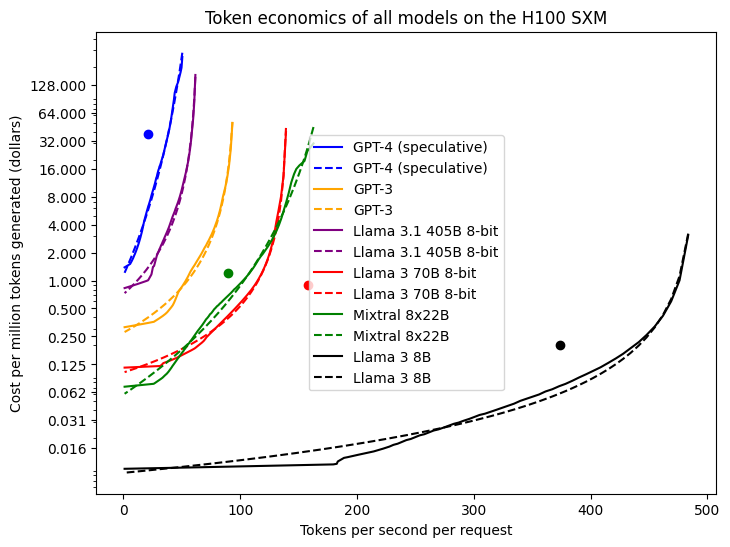

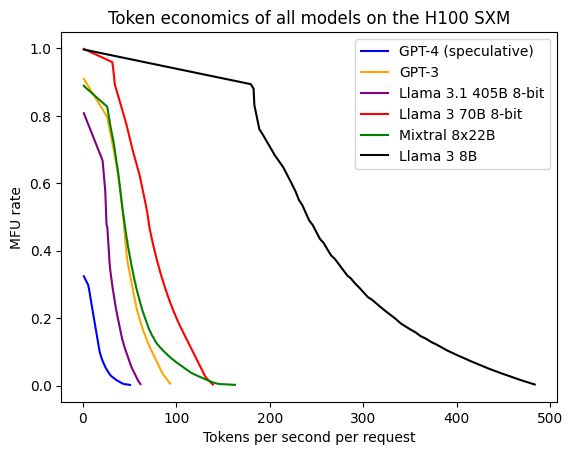

In [23]:
def user_preference_intensity(tokens_per_second_per_request: float, price_per_million_tokens: float):
   return tokens_per_second_per_request**4 / price_per_million_tokens

def preference_maximizing_settings(comparison, token_economics_results):
  results = dict()
  for (comparison_setting, (x_coords, y_coords, gpu_counts, batch_sizes, mfu_values)) in zip(comparison, token_economics_results):
    maximizing_index = np.argmax(user_preference_intensity(x_coords, y_coords))
    results[comparison_setting.name] = {"tokens_per_second_per_request": x_coords[maximizing_index], \
                                        "price_dollars_per_million_tokens": y_coords[maximizing_index], \
                                        "gpus_per_instance": gpu_counts[maximizing_index], \
                                        "batch_size": batch_sizes[maximizing_index], \
                                        "utilization_rate": mfu_values[maximizing_index]
                                       }
  return results

#token_economics_results = pareto_fronts(llama_comparison, section_2_2_token_latency_seconds)
#current_comparison = gpus_comparison
#current_comparison = gpus_long_context_comparison
current_comparison = all_models_comparison
#current_comparison = all_models_comparison_with_spec_dec
#current_comparison = context_length_comparison
#current_comparison = llama_comparison
#current_comparison = quantization_comparison
#current_comparison = spec_dec_comparison
#current_comparison = mistral_large_comparison
#current_comparison = gpt_4_llama_comparison_with_spec_dec

#current_comparison = tpu_test

token_economics_results = pareto_fronts(current_comparison.comparison_list, token_latency_seconds_default, use_pp=False)
#token_economics_results = pareto_fronts(current_comparison, section_2_2_token_latency_seconds)

min_y = min([min(y_coords) for (x_coords, y_coords, gpu_counts, batch_sizes, mfu_values) in token_economics_results])
max_y = max([max(y_coords) for (x_coords, y_coords, gpu_counts, batch_sizes, mfu_values) in token_economics_results])

fig = plt.figure(figsize=(8, 6))

for (comparison_setting, (x_coords, y_coords, gpu_counts, batch_sizes, mfu_values)) in zip(current_comparison.comparison_list, token_economics_results):
  plt.plot(x_coords, y_coords, label=comparison_setting.name, color=comparison_setting.color)
  if comparison_setting.observed_perf != None:
    x_l = []
    y_l = []
    for (x, y) in comparison_setting.observed_perf:
      x_l.append(x)
      y_l.append(y)

    plt.scatter(x_l, y_l, color=comparison_setting.color)

  # Fit the model
  result = fit_lognormal_model(x_coords, y_coords)

  if result.success:
      A_fit, beta_fit, x_m_fit, log_sigma_fit = result.x
      print("Fit succeeded for setting %s!" % (comparison_setting.name))
      print(f"A        = {A_fit:.4f}")
      print(f"beta     = {beta_fit:.4f}")
      print(f"x_m      = {x_m_fit:.4f}")
      print(f"sigma    = {np.exp(log_sigma_fit):.4f}")
      plt.plot(x_coords, model(x_coords, A_fit, beta_fit, x_m_fit), label=comparison_setting.name, color=comparison_setting.color, linestyle="dashed")
  else:
      print("Fit failed for setting %s." % (comparison_setting.name))
      print(result.message)

  opt_index = np.argmax(x_coords)
  print("Maximum throughput for %s: %.2f tokens/second/request (using %.2f GPUs at a batch size of %.2f)" % (comparison_setting.name, x_coords[opt_index], \
                                                                                                             gpu_counts[opt_index], batch_sizes[opt_index]))
print("\n")

preference_max_results = preference_maximizing_settings(current_comparison.comparison_list, token_economics_results)
for setting_name in preference_max_results:
  results_dict = preference_max_results[setting_name]
  print("Preferred throughput for %s: %.2f tokens/second/request at %.2f USD/million output tokens (using %.2f GPUs at a batch size of %.2f)" % (setting_name, results_dict["tokens_per_second_per_request"], \
                                                                                                                                                 results_dict["price_dollars_per_million_tokens"], \
                                                                                                                                                 results_dict["gpus_per_instance"], \
                                                                                                                                                 results_dict["batch_size"]))

plt.xlabel("Tokens per second per request")
plt.ylabel("Cost per million tokens generated (dollars)")

if current_comparison.plot_title == gpt_4_comparison_with_spec_dec.plot_title:
  plt.hlines(y=10, xmin=71.6, xmax=181.9, color='black', linewidth=2, label='GPT-4o price performance range')

plt.yscale("log")
plt.gca().set_yticks([tick for tick in np.logspace(start=-10, stop=10, num=21, base=2) if tick <= max_y and tick >= min_y])
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda y, _: '%.3f' % y))

plt.title(current_comparison.plot_title)
plt.legend()

plt.savefig(current_comparison.file_name + ".pdf")
plt.savefig(current_comparison.file_name + ".png")
plt.savefig(current_comparison.file_name + ".svg")
plt.show()

for (comparison_setting, (x_coords, y_coords, gpu_counts, batch_sizes, mfu_values)) in zip(current_comparison.comparison_list, token_economics_results):
  plt.plot(x_coords, mfu_values, label=comparison_setting.name, color=comparison_setting.color)

plt.xlabel("Tokens per second per request")
plt.ylabel("MFU rate")

plt.title(current_comparison.plot_title)
plt.legend()

plt.savefig("%s_mfu.pdf" % current_comparison.file_name)
plt.savefig("%s_mfu.png" % current_comparison.file_name)
plt.savefig("%s_mfu.svg" % current_comparison.file_name)
plt.show()

In [22]:
print(GPT_4)
print(Mixtral_8x22B)
print(Llama_3_405B)

Model Details:
        Name: GPT-4
        d_model: 12288
        d_ff: 36864
        Depth: 120
        Total FF Params: 1739461754880
        Total Embedding Params: 2463891456
        Num Attention Heads: 96
        d_head: 192
        Group size: 96
        Total Attention Params: 54924410880.0
        Total Params: 1796850057216.0
        Total Active Params: 274821021696.0
        
Model Details:
        Name: Mixtral 8x22B
        d_model: 6144
        d_ff: 16384
        Depth: 56
        Total FF Params: 135291469824
        Total Embedding Params: 393216000
        Num Attention Heads: 48
        d_head: 128
        Group size: 6
        Total Attention Params: 4932501504.0
        Total Params: 140617187328.0
        Total Active Params: 39148584960.0
        
Model Details:
        Name: LLaMa 3 405B
        d_model: 16384
        d_ff: 53248
        Depth: 126
        Total FF Params: 329772957696
        Total Embedding Params: 4202692608
        Num Attention Heads: 128


In [5]:
print(Mistral_Large_2.kv_cache_size_per_input_bytes)

360448.0


In [6]:
print(Mistral_Large_2)

Model Details:
        Name: Mistral Large 2
        d_model: 12288
        d_ff: 28672
        Depth: 88
        Total FF Params: 93012885504
        Total Embedding Params: 805306368
        Num Attention Heads: 96
        d_head: 128
        Group size: 12
        Total Attention Params: 28789702656.0
        Total Params: 122607894528.0
        Total Active Params: 122607894528.0
        
